# SYDE 522 Project Code
Chang Li, Maathusan Rajendram, Anastasia Santasheva, Evan Yeung

## Import Packages


In [150]:
# standard useful packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# validation & normalization methods
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut

# accuracy, error, log loss methods
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

# dim reduction & classification methods 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier

# make matplotlib to show plots inline
%matplotlib inline

# TODO: add ways to select options

## Load  Dataset
* Select a data set (Portugese course or Math course)

In [151]:
# import data from csv
dataframe = pd.read_csv('student-por.csv', usecols = range(0,33)) # select Portugese course dataset
# dataframe = pd.read_csv('student-mat.csv', usecols = range(0,33)) # select Math course dataset

dataset = dataframe.values
dataset.shape

(649, 33)

## Preprocessing

* Convert nominal attributes with Integer + One-Hot Encoding
* Select supervised approache for G3
* NOTE: if we want we can also split further into A,B,C (A= all cols, B=same as A without G2, C=same as B without G1)
    * But leaving this out for now since we know A gives best accuracy

In [152]:
# helper functions for preprocessing
def convertToBinary(df, num_cols):
    df.loc[(df.G3 < 10), 'G3'] = 0
    df.loc[(df.G3 >= 10), 'G3'] = 1
    
    G3 = df.values[:,num_cols-1]
    return G3

def convertToFiveLevel(df, num_cols):
    df.loc[(df.G3 <= 9), 'G3'] = 0
    df.loc[(df.G3 > 9) & (df.G3 <= 11), 'G3'] = 1
    df.loc[(df.G3 > 11) & (df.G3 <= 13), 'G3'] = 2
    df.loc[(df.G3 > 13) & (df.G3 <= 16), 'G3'] = 3
    df.loc[(df.G3 > 16), 'G3'] = 4
    
    G3 = df.values[:,num_cols-1]
    return G3   

def oneHotEncode(df, num_cols):
    cols_to_transform = [
                        'school',
                        'sex',
                        'address',
                        'famsize',
                        'Pstatus',
                        'Mjob',                        
                        'Fjob',
                        'reason',
                        'guardian',
                        'famsup',
                        'schoolsup',
                        'paid',
                        'activities',
                        'nursery',                        
                        'higher',
                        'internet',
                        'romantic',
                        ]
    hot_encoded_df = pd.get_dummies(df, columns = cols_to_transform)
    
    attributes = np.delete(hot_encoded_df.values, obj=num_cols-1, axis=1)
    return attributes

def normalizeData(train_data, test_data):
    scaler = StandardScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    
    return train_data, test_data

# shuffle dataset
np.random.shuffle(dataset)

# find col length
num_cols = dataset.shape[1]

# split one-hot encoded attributes (X) and G3 (Y)
X = oneHotEncode(dataframe, num_cols)

# select supervised approach for G3
# Y = convertToBinary(dataframe, num_cols) # sets G3 to binary
Y = convertToFiveLevel(dataframe, num_cols) # set G3 to five-level scale
# Y = dataset[:,num_cols-1] # set G3 to current state for regression

# after converting G3 set it to type int
Y = Y.astype('int') 

In [153]:
# Y
X.shape

(649, 58)

## Dimensionality Reduction
* PCA & LDA reduction methods

In [154]:
def pcaReduction(train_data, test_data, n_comp):
    pca = PCA(n_components=n_comp)
    train_data = pca.fit_transform(train_data)
    test_data = pca.transform(test_data)
    
    return train_data, test_data

def ldaReduction(train_data, train_target, test_data, n_comp):
    lda = LinearDiscriminantAnalysis(n_components=n_comp)
    train_data = lda.fit_transform(train_data, train_target)
    test_data = lda.transform(test_data)
    
    return train_data, test_data


## Validation Methods
* k-Fold cross validation & Leave-one-out validation
* data gets normalized here

In [155]:
# method to calculate precision, accuracy, confusion matrix
def calcMetric(actual, predicted):
# return precision_score(actual, predicted)
# return confusion_matrix(actual, predicted)
    return accuracy_score(actual, predicted, normalize = True)

def kFoldValidation(n_comp, penalty, n_splits=10):
    kFold = KFold(n_splits=n_splits)
    
    # run on test data
    test_results = []
    train_results = []
    log_loss_results = []
    
    for train_index, test_index in kFold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # normalize data
        X_train, X_test = normalizeData(X_train, X_test)
        
        # reduce dimensionality - comment out both to select none
        X_train, X_test = pcaReduction(X_train, X_test, n_comp)  # select PCA
#         X_train, X_test = ldaReduction(X_train, Y_train, X_test, n_comp)  # select LDA
        
        # build classifier for each set
        clf = buildClf(X_train, Y_train, penalty)
        
        predicted = clf.predict(X_test)
        test_accuracy = calcMetric(Y_test, predicted)
        predicted = clf.predict(X_train)
        train_accuracy = calcMetric(Y_train, predicted)
        
        # log loss calculation
        log_loss_results.append(log_loss(Y_test, clf.predict_proba(X_test)))
        
        test_results.append(test_accuracy)
        train_results.append(train_accuracy)
        
    return np.mean(train_results, axis = 0), np.mean(test_results, axis = 0), np.mean(log_loss_results, axis = 0)

def looValidation(n_comp, penalty):
    loo = LeaveOneOut()
    
    # run on test data
    test_results = []
    train_results = []
    Y_test_prob = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # normalize data
        X_train, X_test = normalizeData(X_train, X_test)
        
        # reduce dimensionality - comment out both to select none
        X_train, X_test = pcaReduction(X_train, X_test, n_comp)  # select PCA
#         X_train, X_test = ldaReduction(X_train, Y_train, X_test, n_comp)  # select LDA
        
        # build classifier for each set
        clf = buildClf(X_train, Y_train, penalty)
        
        predicted = clf.predict(X_test)
        test_accuracy = calcMetric(Y_test, predicted)
        predicted = clf.predict(X_train)
        train_accuracy = calcMetric(Y_train, predicted)
        
        # save probability for log loss calculation
        Y_test_prob.append(clf.predict_proba(X_test)[0])
            
        test_results.append(test_accuracy)
        train_results.append(train_accuracy)
    
    # log loss calculation
    log_loss_value = log_loss(Y, Y_test_prob)

    return np.mean(train_results, axis = 0), np.mean(test_results, axis = 0), log_loss_value

## Classifier Selection
* Select classifer to validate

In [156]:
# method to build classifier
def buildClf(train_data, train_target, penalty):
    
    model = SVC(C=penalty, probability=True, kernel='rbf',gamma=0.0001)
#     model = DecisionTreeClassifier(max_depth = None, max_features = penalty, criterion = "entropy")
#     model = RandomForestClassifier(n_estimators = penalty, max_features=450, criterion = "entropy")
#     model = KNeighborsClassifier(n_neighbors=penalty, p=1)
#     model = BaggingClassifier(DecisionTreeClassifier(max_features = penalty, criterion = "entropy"), max_samples=0.5, max_features=6)
    
    model.fit(train_data, train_target)
    return model

## Obtain Accuracy, Log Loss & Error
* Select k-Fold, loo validation, or run both
* Adjust array of penalty parameters
* Graphs error and log loss

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


-----C=1-----
-----Train-----
Accuracy: 0.30970724191063176
-----Test-----
Accuracy: 0.30970724191063176
Log Loss: 0.8398001706383842

-----C=10-----
-----Train-----
Accuracy: 0.607668017272537
-----Test-----
Accuracy: 0.5377503852080123
Log Loss: 0.7921119045184242

-----C=100-----
-----Train-----
Accuracy: 0.8581269379291979
-----Test-----
Accuracy: 0.7688751926040062
Log Loss: 0.5457089765678634

-----C=1000-----
-----Train-----
Accuracy: 0.96410669786376
-----Test-----
Accuracy: 0.8690292758089369
Log Loss: 0.3401287304705243

-----C=10000-----
-----Train-----
Accuracy: 1.0
-----Test-----
Accuracy: 0.9691833590138675
Log Loss: 0.12772324249354777



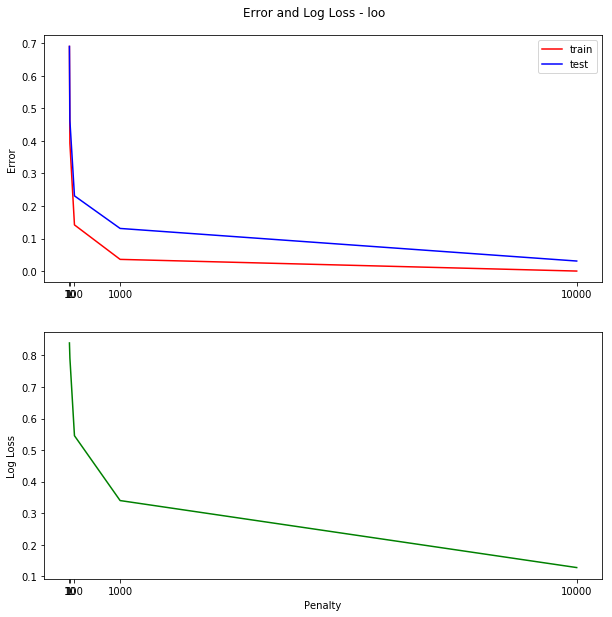

In [157]:
# input reduced dimension
n_comp = 50

# input penalty iterations - can tune other params in classifer selection method above
hyperparams = [1, 10, 100, 1000, 10000]

# select validation type
# val_type = "k-Fold"
val_type = "loo"

# results array format: [[train], [test], [log loss]]
results = [[],[],[]]

for penalty in hyperparams:
    # calculate train error, test error and log loss for specific param
    if (val_type == "k-Fold"):
        train_res, test_res, log_loss_val = kFoldValidation(n_comp, penalty, 10)
    elif (val_type == "loo"):
        train_res, test_res, log_loss_val = looValidation(n_comp, penalty)
    
    # save error and log loss for each penalty for graph
    results[0].append(1-train_res)
    results[1].append(1-test_res)
    results[2].append(log_loss_val)

    print ("-----C={}-----".format(penalty))
    print ("-----Train-----")
    print ("Accuracy: {}".format(train_res))
    print ("-----Test-----")
    print ("Accuracy: {}".format(test_res))
    print ("Log Loss: {}\n".format(log_loss_val))
    
# create graph for penalty iterations
f, axarr = plt.subplots(2, sharex=False)
f.suptitle('Error and Log Loss - {}'.format(val_type), y = 0.92)
f.set_size_inches(10, 10)

# subplot 1: error plot
axarr[0].set_ylabel('Error')
axarr[0].plot(hyperparams, results[0], color='r', label='train')
axarr[0].plot(hyperparams, results[1], color='b', label='test')
axarr[0].set_xticks(hyperparams)
axarr[0].legend()

# subplot 2: log loss plot
axarr[1].set_ylabel('Log Loss')
axarr[1].plot(hyperparams, results[2], color='g', label='log loss')
axarr[1].set_xticks(hyperparams)
axarr[1].set_xlabel('Penalty')
plt.show()